In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 가져오기

In [2]:
with open("../btc_usd_1d.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)

                   o         h         l         c             v
ot                                                              
2014-11-29    376.42    386.60    372.25    376.72  2.746157e+06
2014-11-30    376.57    381.99    373.32    373.34  1.145567e+06
2014-12-01    376.40    382.31    373.03    378.39  2.520662e+06
2014-12-02    378.39    382.86    375.23    379.25  2.593576e+06
2014-12-03    379.25    383.00    374.23    376.67  2.998358e+06
...              ...       ...       ...       ...           ...
2022-01-20  41733.21  43518.69  40554.14  40736.05  2.425153e+03
2022-01-21  40654.72  41115.58  35423.00  36495.46  6.201046e+03
2022-01-22  36447.37  36825.98  34000.00  35091.11  4.510372e+03
2022-01-23  35084.79  36574.47  34624.59  36293.62  2.533704e+03
2022-01-24  36262.21  36276.86  35917.44  35917.44  3.775357e+01

[2614 rows x 5 columns]


In [3]:
data

,o,h,l,c,v
ot,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06
2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06
2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06
2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06
2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...
2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03


# 1. 간단한 모형 테스트

## 윈도우 크기 및 배치 사이즈

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=50
BATCH_SIZE=32

## 데이터 전처리

In [ ]:
data.columns = ['Open','High','Low','Close','Volume']

In [ ]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

In [ ]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

## 데이터 split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_test.shape, y_test.shape

In [ ]:
x_train

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

## Modeling

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

## 결과

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
model.summary()

# 2. 단일 채널 비트코인 가격 예측

# 3. 다중 채널 비트코인 가격 예측

## 데이터 전처리

In [20]:
data.columns = ['Open','High','Low','Close','Volume']

In [21]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[3.18199066e-03, 2.52605283e-03, 3.32614195e-03, 3.18589848e-03,
        3.55568085e-03],
       [3.18421666e-03, 2.45903451e-03, 3.34233013e-03, 3.13574788e-03,
        1.48326158e-03],
       [3.18169386e-03, 2.46368654e-03, 3.33794268e-03, 3.21067703e-03,
        3.26371389e-03],
       ...,
       [5.38474529e-01, 5.32267068e-01, 5.12085159e-01, 5.18259121e-01,
        5.83995879e-06],
       [5.18253856e-01, 5.28610717e-01, 5.21534670e-01, 5.36101310e-01,
        3.28059996e-06],
       [5.35726757e-01, 5.24284183e-01, 5.41094382e-01, 5.30519756e-01,
        4.88827305e-08]])

In [22]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

In [23]:
# data를 numpy형태로 전환

seq=df.to_numpy()

## 윈도우 크기와 수평선 크기

In [24]:
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [25]:
# 윈도우 w와 수평선 h

w = 100   # 윈도우는 이전 요소 몇 개를 볼 것인지
h = 10    # 수평선은 얼마나 먼 미래를 예측할 것인지

In [26]:
X, Y = seq2dataset(seq, w, h)

In [27]:
print(X.shape, Y.shape)

(2505, 100, 5) (2505, 5)


In [28]:
print(X[0], Y[0])

[[3.18199066e-03 2.52605283e-03 3.32614195e-03 3.18589848e-03
  3.55568085e-03]
 [3.18421666e-03 2.45903451e-03 3.34233013e-03 3.13574788e-03
  1.48326158e-03]
 [3.18169386e-03 2.46368654e-03 3.33794268e-03 3.21067703e-03
  3.26371389e-03]
 [3.21122544e-03 2.47168222e-03 3.37122679e-03 3.22343724e-03
  3.35812190e-03]
 [3.22398783e-03 2.47371748e-03 3.35609765e-03 3.18515661e-03
  3.88222656e-03]
 [3.18570066e-03 2.41542172e-03 3.14096125e-03 3.01497099e-03
  4.27006434e-03]
 [3.01548597e-03 2.39943036e-03 3.20117523e-03 3.15963619e-03
  4.31391354e-03]
 [3.16017588e-03 2.38634652e-03 3.31192055e-03 3.16141668e-03
  1.11577864e-03]
 [3.16195668e-03 2.39376070e-03 3.33990947e-03 3.18812410e-03
  1.18306458e-03]
 [3.18866866e-03 2.39303382e-03 3.21040401e-03 3.00621689e-03
  4.73274504e-03]
 [3.00673038e-03 2.21901878e-03 2.89828980e-03 2.79671202e-03
  9.55092856e-03]
 [2.79718972e-03 2.04834740e-03 2.94761081e-03 2.76169562e-03
  2.98361775e-03]
 [2.76216734e-03 2.20375431e-03 2.835201

## 데이터셋 split

In [29]:
split=int(len(X)*0.7)

In [30]:
x_train=X[0:split]
y_train=Y[0:split]
x_test=X[split:]
y_test=Y[split:]

## Modeling

In [108]:
model = Sequential()
model.add(LSTM(units=16,activation='tanh',input_shape=x_train[0].shape))
model.add(Dense(16, activation="relu"))
model.add(Dense(5))

In [109]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [110]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [111]:
hist=model.fit(x_train,y_train,epochs=200,batch_size=16,validation_data=(x_test,y_test),callbacks=[checkpoint, earlystopping], verbose=1)

Epoch 1/200
109/110 [============================>.] - ETA: 0s - loss: 8.7165e-04 - mse: 0.0017
Epoch 1: val_loss improved from inf to 0.03985, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 4s 25ms/step - loss: 8.7021e-04 - mse: 0.0017 - val_loss: 0.0398 - val_mse: 0.0797
Epoch 2/200
108/110 [============================>.] - ETA: 0s - loss: 3.4898e-04 - mse: 6.9795e-04
Epoch 2: val_loss improved from 0.03985 to 0.03949, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 3s 23ms/step - loss: 3.4649e-04 - mse: 6.9299e-04 - val_loss: 0.0395 - val_mse: 0.0790
Epoch 3/200
110/110 [==============================] - ETA: 0s - loss: 2.9525e-04 - mse: 5.9049e-04
Epoch 3: val_loss improved from 0.03949 to 0.03921, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 3s 24ms/step - loss: 2.9525e-04 - mse: 5.9049e-04 - val_loss: 0.0392 - val_mse: 0.0784
Epoch 4/200
108/110 [============================>.]

## 모델 평가

In [112]:
ev=model.evaluate(x_test, y_test, verbose=1)

24/24 [==============================] - 0s 7ms/step - loss: 0.0339 - mse: 0.0678   


In [113]:
print("손실 함수:", ev[0], "MSE", ev[1])

손실 함수: 0.03391161933541298 MSE 0.06782323867082596


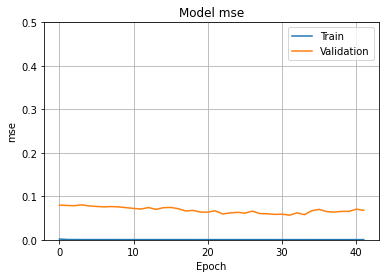

In [114]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.ylim([0,0.5])
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

In [115]:
pred = model.predict(x_test)

In [116]:
pred.shape

(752, 5)

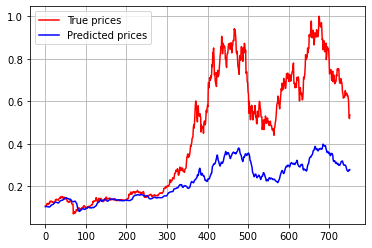

In [117]:
#'Open'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,0], color='red')
plt.plot(x_range,pred[x_range][:,0], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

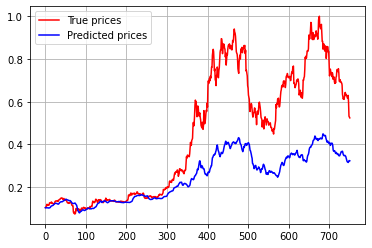

In [118]:
#'High

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,1], color='red')
plt.plot(x_range,pred[x_range][:,1], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

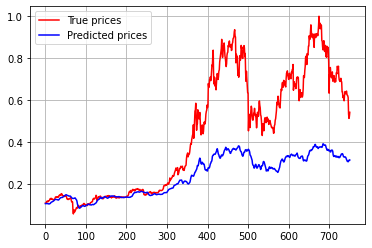

In [119]:
#'Low'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,2], color='red')
plt.plot(x_range,pred[x_range][:,2], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

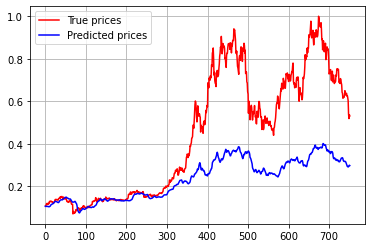

In [120]:
#'Close'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,3], color='red')
plt.plot(x_range,pred[x_range][:,3], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

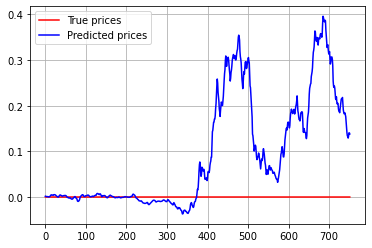

In [121]:
#'Volume'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,4], color='red')
plt.plot(x_range,pred[x_range][:,4], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

In [122]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 16)                1408      
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,765
Trainable params: 1,765
Non-trainable params: 0
_________________________________________________________________
